# COMP47670 Assignment 2

## Implementing text classification on customer review data

### Conor McFeely

### Student No: 19204085

This assignment involves scraping data from a set of webpages, the data is in form of reviews of businesses in specific categories. The reviews will have the customers review and a star rating out of 5 for the service of that particular business.

Once the data has been scraped, it will need to be stored in a dataset with the star column and it's values changed to reflect if the review is positive for negative. If the star rating is greater than 3 it will be reflected as 'Positive' and if the rating is is equal to 3 or less than 3 it will be reflected as a 'Negative' review. Preprocessing techniques will then be implemented on the review column to normalise the data before text classification begins. Text Classification will analyse the review text column, and hopefully it will provide some meaningful insight in helping to accurately predict the ratings of the reviews for each business and category.

In [132]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
import urllib.request
import csv
import nltk
import nltk.tokenize.punkt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,accuracy_score,recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## 1. Selecting and Scrapping the reviews and rating

The three review categories I have chosen are Automotive, Gym and Resturants. From the main page, I am extracting the URL and i have created a list with the ends of the URL for each category.

The below methods will fetch the reviews from each business inside the categories and also the review ranking based on the img and if it's >= 4 it will be positive anything else will be negative. This will then be written to a .csv file using the elements in the categories list and the correspoinding scraped information to determine which will be written.

In [133]:
# Create variable for the webpage
url = 'http://mlg.ucd.ie/modules/yalp/'
# Creating array of chosen categories
categories = ['automotive_list.html', 'gym_list.html', 'restaurants_list.html']

In [134]:
for category in categories:
    file_name = category + '.csv'
    with open(file_name, 'w', newline='', encoding='utf-8') as file:
        file = csv.writer(file)
        file.writerow(['comment', 'rating'])
        res = requests.get(url + category)
        soup = BeautifulSoup(res.text, 'html.parser')
        for a in soup.find_all('a', href=True):
            business_url = 'http://mlg.ucd.ie/modules/yalp/' + str(a['href'])
            inner_res = requests.get(business_url)
            inner_soup = BeautifulSoup(inner_res.text, 'html.parser')
            for i in inner_soup.findAll("div", {"class": "review"}):
                comment = i.find("p", {"class": "review-text"})
                img = i.find('img', alt=True)
                rating = img['alt'].split('-')[0]
                if int(rating) >= 4:
                    file.writerow([comment.text.strip(), "positive"])
                else:
                    file.writerow([comment.text.strip(), "negative"])

In [135]:
# Reading in the csv files as data frames
autoDF = pd.read_csv('automotive_list.html.csv')
gymDF = pd.read_csv('gym_list.html.csv')
resturantsDF = pd.read_csv('restaurants_list.html.csv')

## 2. Pre-processing the data and build a classification model

### (a) Pre-processing

The scraped data now needs to be preprocessed and normalised to help with building the classification model and to optimise the results. This method will be used to normalise the data:
    1. Stop words need to be removed as they hamper the effiencey of the data
    2. Any special or numeric characters
    3. Text must be converted to lower case
    
Each of the three categories will have this preprocessing completed for the begining of the classfication model. Once the pre-processing is complete I will check to see that there is no null data in the column and will check how many positive and how many negative reviews there is.

In [136]:
def preprocessing_comment(df):
    df["comment"] = df['comment'].str.replace('[^\w\s]','')
    df["comment"] = df["comment"].str.lower()
    df['comment'] = df['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['comment'] = df['comment'].str.replace('\d+', '')

    return df

In [137]:
# Cleaning the data frame with the preprocessing method
autoDF = preprocessing_comment(autoDF)
gymDF = preprocessing_comment(gymDF)
resturantsDF = preprocessing_comment(resturantsDF)

The below function should use lemmatization to convert all words into their best form, lemmatization will consider the context and converts the word to its meaningful base form.

In [138]:
def convert(text):
    lemmatized_text = []
    for i in text.split():
        lemmatized_text.append(str(wordnet_lemmatizer.lemmatize(i,pos="v")))
    return ' '.join(lemmatized_text)

In [139]:
# Cleaning comment column on each data frame
autoDF['comment'] = autoDF['comment'].apply(lambda x: convert(x))
gymDF['comment'] = gymDF['comment'].apply(lambda x: convert(x))
resturantsDF['comment'] = resturantsDF['comment'].apply(lambda x: convert(x))

In [140]:
autoDF.isnull().sum()

comment    0
rating     0
dtype: int64

In [141]:
autoDF.groupby('rating')['rating'].count()

rating
negative     788
positive    1212
Name: rating, dtype: int64

In [142]:
autoDF.head()

,comment,rating
0,man work tonight rude real jerk need help get ...,negative
1,chris rude person give attitude change people ...,negative
2,one favorite gas station stop store always cle...,positive
3,oh thank heaven seven eleven dont know thank s...,negative
4,five star guy work weekday mornings around ami...,positive


Text(0, 0.5, 'Number of reviews')

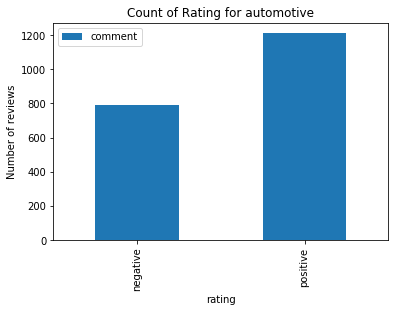

In [143]:
ratioAuto = autoDF.groupby("rating").count()
ratioAuto.plot.bar()
plt.title('Count of Rating for automotive')
plt.ylabel('Number of reviews')

In [144]:
gymDF.isnull().sum()

comment    0
rating     0
dtype: int64

In [145]:
gymDF.groupby('rating')['rating'].count()

rating
negative     701
positive    1299
Name: rating, dtype: int64

In [146]:
gymDF.head()

,comment,rating
0,youre look box east valley highly recommend gy...,positive
1,really excite try fun workout routine would al...,negative
2,interest take box bootcamp class research find...,negative
3,work box bout months love price reasonable alt...,positive
4,place literally kick butt every single time ac...,positive


Text(0, 0.5, 'Number of reviews')

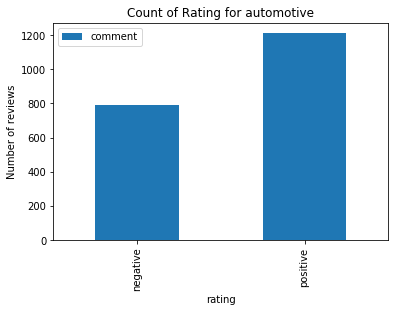

In [147]:
gymAuto = gymDF.groupby("rating").count()
ratioAuto.plot.bar()
plt.title('Count of Rating for automotive')
plt.ylabel('Number of reviews')

In [148]:
resturantsDF.isnull().sum()

comment    0
rating     0
dtype: int64

In [149]:
resturantsDF.groupby('rating')['rating'].count()

rating
negative     838
positive    1162
Name: rating, dtype: int64

In [150]:
resturantsDF.head()

,comment,rating
0,husband rare afternoon decide try place friend...,negative
1,years think wine store sister stop tell go nic...,positive
2,place charm go husband love simple clean decor...,positive
3,want try place couple years finally stop last ...,positive
4,decor look ok layout busy difficult walk sitta...,negative


Text(0, 0.5, 'Number of reviews')

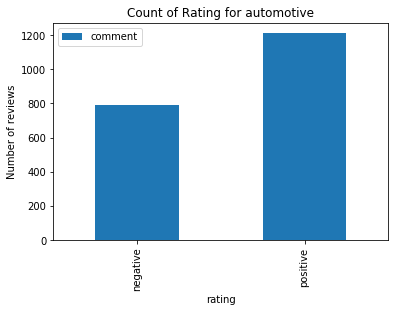

In [151]:
resturantsratio = resturantsDF.groupby("rating").count()
ratioAuto.plot.bar()
plt.title('Count of Rating for automotive')
plt.ylabel('Number of reviews')

### (b) Classification Model - Naive Bayes

The classifier I have chosen to create the classification model will be Naive Bayes. I will use thos to distinguish between "positive" and "negative" reviews, and it will help predict if a review is either positive or negative based on the classifier that has been built.

Naive Bayes is suited as it is based on a theory of two events in this case, positive or negative. Along with that Naive Bayes is really fast as it only needs one pass over the data and it's not effected by sparse data. The results are still highly competitive even with the high speed and has been known to be used regulary in tasks of text classification and sentiment analysis such as this.

In [152]:
# Combine the clean dataframe of each category to build a stronger classifier
cleanDF = autoDF.append(gymDF).append(resturantsDF)
cleanDF['comment'] = cleanDF['comment'].apply(lambda x: convert(x))
cleanDF.head()

,comment,rating
0,man work tonight rude real jerk need help get ...,negative
1,chris rude person give attitude change people ...,negative
2,one favorite gas station stop store always cle...,positive
3,oh thank heaven seven eleven dont know thank s...,negative
4,five star guy work weekday mornings around ami...,positive


In [153]:
# Checking to see if the total matches each individual category and it does
cleanDF.groupby('rating')['rating'].count()

rating
negative    2327
positive    3673
Name: rating, dtype: int64

### Building the model

Using the combined cleaned data from auto, gym and resturants I created a Naive Bayes classifier to help distingush between positive and negative comments. A confusion matrix will be used to describe the performance of the model on the test data and it helped illustrate the performance.

The data will be split as 70% for training and 30% for test data, along with the sklearn library help to create the model and distiguish the training and test data.

In [154]:
# Testing the predictions on the combined cleaned data frame
X = cleanDF.comment
y = cleanDF.rating

# Split the data into a 70 training and 30 as test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Create a NB classifier with the help of Tfidf
nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])

# Train the model using the training data sets
nb = nb.fit(X_train, y_train)

# predict the response of the test data
y_pred = nb.predict(X_test)

### (c) Testing predictions

A confusion matrix was used to test the predictions of the Naive Bayes classification model, this helped illustate the performance of the classification model in three key areas. The accuracy for the model was at 82.67% which indicates how many the model got correct, the recall score was extremley high at 98.7% meaning the intuitively ability to find all the postive samples. The precision score is still pretty good at 78% and this is the ratio of correctly predicted positive observations to the total predicted observations.

Accuracy Score  0.8266666666666667
Recall Score  0.9824884792626728
Precision Score  0.7844002943340692
Normalized confusion matrix
[[0.59020979 0.40979021]
 [0.01751152 0.98248848]]


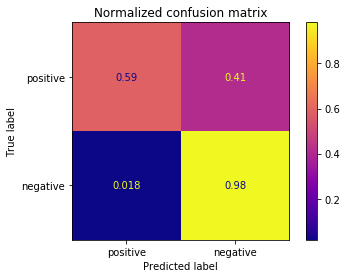

In [155]:
my_tags = ['positive','negative']
print("Accuracy Score ",accuracy_score(y_test,y_pred))
print("Recall Score ",recall_score(y_test,y_pred,average="binary", pos_label="positive"))
print("Precision Score ",precision_score(y_test,y_pred,average="binary", pos_label="positive"))

titles_options = [("Normalized confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X_test, y_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

In [156]:
def predict(X,y):
    # Split the data into a 70 training and 30 as test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    # Create a NB classifier with the help of Tfidf
    nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
    
    # Train the model using the training data sets
    nb = nb.fit(X_train, y_train)
    
    # predict the response of the test data
    y_pred = nb.predict(X_test)
    
    print("Accuracy Score  ",accuracy_score(y_test,y_pred))
    print("Recall Score    ",recall_score(y_test,y_pred,average="binary", pos_label="positive"))
    print("Precision Score ",precision_score(y_test,y_pred,average="binary", pos_label="positive"))
    print(confusion_matrix(y_test,y_pred))

The below data shows that recall scores are great for all of the models and the accuracy are high for both Automotive reviews and the gym reviews, there is a slight decrease in the accuracy score for resturants and a precesion score to go along with that. But based on the scores provided I'm happy to proceed with the Naive Bayes classification model to begin stype three.

In [157]:
print("\nThe classification model on Automotive")
auto_model = predict(autoDF.comment,autoDF.rating)

print("\nThe classification model on Gym")
gym_model = predict(gymDF.comment,gymDF.rating)

print("\nThe classification model on Resturants")
resturant_model = predict(resturantsDF.comment,resturantsDF.rating)


The classification model on Automotive
Accuracy Score   0.8383333333333334
Recall Score     0.9891304347826086
Precision Score  0.7964989059080962
[[139  93]
 [  4 364]]

The classification model on Gym
Accuracy Score   0.8466666666666667
Recall Score     0.9926108374384236
Precision Score  0.8191056910569106
[[105  89]
 [  3 403]]

The classification model on Resturants
Accuracy Score   0.7933333333333333
Recall Score     0.9857549857549858
Precision Score  0.7440860215053764
[[130 119]
 [  5 346]]


## 3. Evaluate the preformance of Classification models

The final stage involves evaluating the performance of each classification models when they're applied to data from specific categories. This will involve using a trained classification model on the automotive data frame and using it to evaluate the performance of the gym and resturant data. Then using a trained classification model on the gym data and then use that on the automotive and resturants category and finally using a classification on the resturants category and evaluate it's performance on the automotive and gym data.

The below isn't an optimal way, i tried to make a function like the one above but wasn't managing to call the correct data that i needed to evaluate the performance

In [158]:
X = autoDF.comment
y = autoDF.rating
X1 = gymDF.comment
y1 = gymDF.rating
X2 = resturantsDF.comment
y2 = resturantsDF.rating

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 42)

nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])

nb1 = nb.fit(X_train, y_train)
nb2 = nb.fit(X1_train, y1_train)
nb3 = nb.fit(X2_train, y2_train)

y_pred = nb.predict(X_test)
y_pred1 = nb2.predict(X1_test)
y_pred2 = nb3.predict(X2_test)

### Automotive Dataset model performance on Gym and Resturants

Accuracy Score of Auto > Gym  0.5333333333333333
Recall Score of Auto > Gym  0.5394088669950738
Precision Score of Auto > Gym  0.7019230769230769
Auto > Gym confusion matrix
[[0.78865979 0.21134021]
 [0.04926108 0.95073892]]


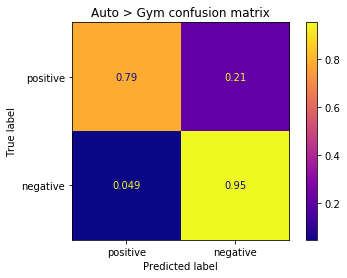

In [159]:
my_tags = ['positive','negative']
print("Accuracy Score of Auto > Gym ",accuracy_score(y1_test,y_pred))
print("Recall Score of Auto > Gym ",recall_score(y1_test,y_pred,average="binary", pos_label="positive"))
print("Precision Score of Auto > Gym ",precision_score(y1_test,y_pred,average="binary", pos_label="positive"))

titles_options = [("Auto > Gym confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X1_test, y1_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

Accuracy Score of Auto > Resturants  0.5316666666666666
Recall Score of Auto > Resturants  0.5441595441595442
Precision Score of Auto > Resturants  0.6121794871794872
Auto > Resturants confusion matrix
[[0.52208835 0.47791165]
 [0.01424501 0.98575499]]


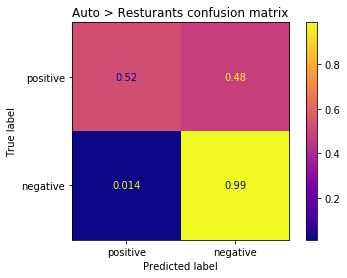

In [160]:
my_tags = ['positive','negative']
print("Accuracy Score of Auto > Resturants ",accuracy_score(y2_test,y_pred))
print("Recall Score of Auto > Resturants ",recall_score(y2_test,y_pred,average="binary", pos_label="positive"))
print("Precision Score of Auto > Resturants ",precision_score(y2_test,y_pred,average="binary", pos_label="positive"))

titles_options = [("Auto > Resturants confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X2_test, y2_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

### Gym Dataset model performance on Automotive and Resturants

Accuracy Score of Gym > Auto  0.5883333333333334
Recall Score of Gym > Auto  0.7445652173913043
Precision Score of Gym > Auto  0.6416861826697893
Gym > Auto confusion matrix
[[0.89224138 0.10775862]
 [0.2201087  0.7798913 ]]


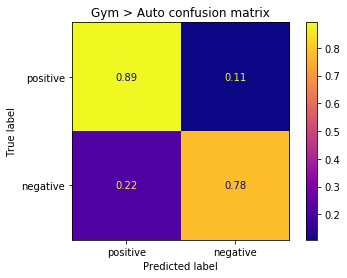

In [161]:
my_tags = ['positive','negative']
print("Accuracy Score of Gym > Auto ",accuracy_score(y_test,y_pred1))
print("Recall Score of Gym > Auto ",recall_score(y_test,y_pred1,average="binary", pos_label="positive"))
print("Precision Score of Gym > Auto ",precision_score(y_test,y_pred1,average="binary", pos_label="positive"))

titles_options = [("Gym > Auto confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X_test, y_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

Accuracy Score of Gym > resturants  0.5066666666666667
Recall Score of Gym > resturants  0.6866096866096866
Precision Score of Gym > resturants  0.5644028103044496
Gym > resturants confusion matrix
[[0.52208835 0.47791165]
 [0.01424501 0.98575499]]


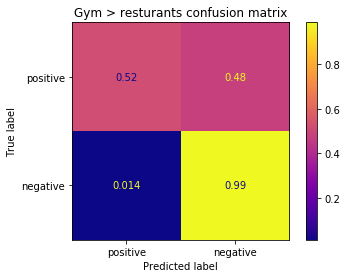

In [162]:
my_tags = ['positive','negative']
print("Accuracy Score of Gym > resturants ",accuracy_score(y2_test,y_pred1))
print("Recall Score of Gym > resturants ",recall_score(y2_test,y_pred1,average="binary", pos_label="positive"))
print("Precision Score of Gym > resturants ",precision_score(y2_test,y_pred1,average="binary", pos_label="positive"))

titles_options = [("Gym > resturants confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X2_test, y2_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

### Resturants Dataset model performance on Automotive and Gym

Accuracy Score of Resturants > Auto  0.5816666666666667
Recall Score of Resturants > Auto  0.7907608695652174
Precision Score of Resturants > Auto  0.6258064516129033
Resturants > Auto confusion matrix
[[0.89224138 0.10775862]
 [0.2201087  0.7798913 ]]


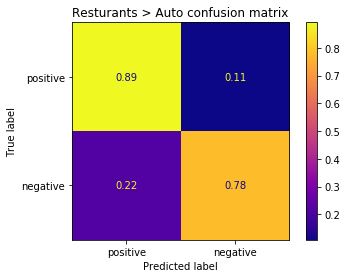

In [163]:
my_tags = ['positive','negative']
print("Accuracy Score of Resturants > Auto ",accuracy_score(y_test,y_pred2))
print("Recall Score of Resturants > Auto ",recall_score(y_test,y_pred2,average="binary", pos_label="positive"))
print("Precision Score of Resturants > Auto ",precision_score(y_test,y_pred2,average="binary", pos_label="positive"))

titles_options = [("Resturants > Auto confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X_test, y_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

Accuracy Score of Resturants > Auto  0.585
Recall Score of Resturants > Auto  0.7660098522167488
Precision Score of Resturants > Auto  0.6688172043010753
Resturants > Auto confusion matrix
[[0.78865979 0.21134021]
 [0.04926108 0.95073892]]


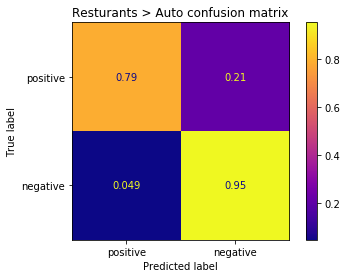

In [164]:
my_tags = ['positive','negative']
print("Accuracy Score of Resturants > Auto ",accuracy_score(y1_test,y_pred2))
print("Recall Score of Resturants > Auto ",recall_score(y1_test,y_pred2,average="binary", pos_label="positive"))
print("Precision Score of Resturants > Auto ",precision_score(y1_test,y_pred2,average="binary", pos_label="positive"))

titles_options = [("Resturants > Auto confusion matrix", 'true')]
class_names = ["positive","negative"]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X1_test, y1_test, display_labels=class_names,
    cmap=plt.cm.plasma,normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

### Analysis of performance on different datasets

Training and testing data on different categories did not produce as strong result, even though the principles were the same. The accuray level managed to reach above 50% in all cases but it struggled to reach the optimisation of data if it was using the classifer created for the same category.

The lack of success with the trained model on another category could be because it didn't identify the same new keywords in the classification, as it was only given keywords on the classification of the model it was trained on and there wouldn't be mant similarities in the use of text for automotive, gym and restuarants.

Even though the accuracy has shrunk the level of similarity between accuracy of each training set on the different categories all were within 8% of each other. This could be because of the difference in key words like mentioned before and also it could be down to the use of pre-processing to remove keywords. In an article by towards science (https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52) they highlight the importance of stop words for sentiment of a sentence and how this pre-processing technique may not actually improve the model performance.

Different file size and after the preprocessing the files may be missing key information. If i was doing it again i would debate not using lemmatization as most words in the english dictionary can take several forms and several meanings and that could cause a keyword to change the classification of a specific review. It doesn't consider spelling mistakes or if the review is in a foreign language.

1. The accuracy of Automotive on gym had a small accuracy of 0.53 and the accuracy on Resturants 0.51 which shows that it was consistent but had no true accuracy

2. The accuracy of Gym on Automotives had a small accuracy of 0.58 and the accuracy on Resturants was even lower with 0.51 which helps highlight the possible difference in key words.

3. The accuracy of Resturants on Automotives had a a slighty better accuracy than any other model of 0.58 and the accuracy on gym was the same with 0.58.

The most efficent model was the combined preprocessed information of all three categories with it tested on each model at 80% or greater showing that there was a possibility of more efficent pre-processing as more information it was easier for the model to indentify the keywords for each. The negative accuracy across all the categories showed to have the greatest accuracy and success the positive was still good but not near as efficent.

The good sign from the models on each category shows that the precission and recall performs better than the accuracy and in some cases this can be a greater indication to the success of the implemented model. If I was to run it again I would trim or distinguist the max or minimun amount of data has to be used so there is not a difference on how much is used between datasets as each data had different amount of positive and negative reviews.

Moreover there needs to be more thought put into the pre-processing techniques to help improve the efficency on each dataset. The optimised way would be using the combined data and use that on each category to have a better accuracy as it has a wider abundance of keywords and if you're looking for optimal results the training and test data needs to be used for the specific categories unless the categories are similar in size of dataset and similar amount of positive and negative reviews.
